# desc-wfmon/monexp.ipynb: Monitor explorer example

We use the classes in desc-wfmon to view monitoring data from DESC gen3 parsl jobs.

Typically, this file is copied to the area where the jobs were run.

First setup to use the local install area and then import the the system (sysmon) and process (wfmon) explorers. 

See desc-wfmon/install.ipynb to install that package in the local directory and create the setup on the first line. 

In [1]:
import sys
import os
homedir = os.getenv('HOME')
print(f"Current directory is {os.getcwd()}")
srcdir = f"{homedir}/desc/dev"
nbdir = srcdir + '/desc-wfmon/ipynb'
%run $nbdir/setup.ipynb
%run install/setup.py
print(f"Python version is {sys.version}")
print(f"Python search path starts with {sys.path[0]}:{sys.path[1]}:{sys.path[2]}")
!pwd
import pandas
import numpy
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import desc.wfmon
import desc.sysmon
for pkg in [desc.wfmon, desc.sysmon]:
    print(f"{pkg} version is {pkg.__version__}")


Current directory is /global/u2/d/dladams/desc/rundirs/ptest05
Setting up desc-wfmon
Python version is 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
Python search path starts with ./install/noconda
/global/u2/d/dladams/desc/rundirs/ptest05
TestMonDbReader:ctor: Done.
<module 'desc.wfmon' from '/global/u2/d/dladams/desc/rundirs/ptest05/./install/noconda/desc/wfmon/__init__.py'> version is 0.0.16.dev2
<module 'desc.sysmon' from '/global/u2/d/dladams/desc/rundirs/ptest05/./install/noconda/desc/sysmon/__init__.py'> version is 0.0.16.dev2
Python version is 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
Python search path starts with ./install/noconda:/global/u2/d/dladams/desc/rundirs/ptest05:
/global/u2/d/dladams/desc/rundirs/ptest05
<module 'desc.wfmon' from '/global/u2/d/dladams/desc/rundirs/ptest05/./install/noconda/desc/wfmon/__init__.py'> version is 0.0.16.dev2
<module 'desc.sysmon' from '/global/u2/d/dladams/desc/rundirs/ptest05/./install/noconda/desc/sysmon/__init__.py'> v

## Configuration
Define some useful constants and specify the location of the monitoring data files. Set dir to point to your area.

In [2]:
# Read the config.
%run monexp.py

# Defaults for configuration.
class monexp_def:
    dir = os.getcwd()
    name = os.path.basename(os.getcwd())
    stunit = 'minute'
    sbunit = 'gb'
    
# Set defaults for any missing parameters.
if 'monexp' not in dir():
    monexp = monexp_def
else:
    for nam in ['dir', 'name', 'stunit', 'sbunit']:
        if not hasattr(monexp, nam):
            setattr(monexp, nam, getattr(monexp_def, nam))
        
# Time conversions and plotting units.
tunits = {'second':1, 'minute':60, 'hour':3600, 'day':24*3600}
stunit = monexp.stunit
tunit = tunits[stunit]

# Memory and I/O conversion plotting units.
bunits = {'mb':2**20, 'gb':2**30}
gb = bunits['gb']
sbunit = monexp.sbunit
bunit = bunits[sbunit]
bunit_sys = bunit/gb

# Time range for the plots
# if tmax <= tmin, it will be reset with the data below
tmin = 0.0
tmax = 60

# Plot size
pdx = 20
pdy = 6

line = '-----------------------------------------------------------'
fread = monexp.dir + '/README.txt'
if os.path.exists(fread):
    fin = open(fread, 'r')
    #readme = fin.read().strip()
    readme = fin.readlines()
    with open(fread) as fin:
        readme = [line.rstrip() for line in fin]
else:
    raise Exception('README.txt not found')
print('README:')
for line in readme: print(line)
pttl = monexp.name + ": " + readme[0]
print(f"Plot title: {pttl}")
pfx = monexp.name
print(f"Plot file prefix: {pfx}")
sfx = '.png'
print(f"Plot file suffix: {sfx}")
plt.rc('font', size=16)
plt.rc('savefig', facecolor='white', bbox='tight')
plt.rc('axes', titlesize='medium')

README:
15Mar2022: perlmutter-si-90GB sfp_Y1_4430_24, w_2022_10-dev4, dtproc=3s
Plot title: ptest05: 15Mar2022: perlmutter-si-90GB sfp_Y1_4430_24, w_2022_10-dev4, dtproc=3s
Plot file prefix: ptest05
Plot file suffix: .png


## Fetch system-level monitoring data

System level monitoring data is collected using *desc.sysmon*. The data is in csv format and is read here with *pandas*.

The column names follow from those of the corresponding *psutil* variables.

We fetch the number of CPUs and total memory and check both are consistent for all samples.

In [3]:
sym = pandas.read_csv(monexp.dir + '/sysmon.csv')
print(f"System monitor sample count: {len(sym)}")
print(f"System monitor columns:")
for cnam in sym.columns:
    print(f"  {cnam}")

assert(len(sym.cpu_count.unique()) == 1)
ncpu = sym.cpu_count[0]
print(f"CPU count is {ncpu:.0f}")

assert(len(sym.mem_total.unique()) == 1)
maxmem = sym.mem_total[0]/bunit_sys
print(f"Total memory is {maxmem:.1f} {sbunit}")


System monitor sample count: 716
System monitor columns:
  time
  cpu_count
  cpu_percent
  cpu_user
  cpu_system
  cpu_idle
  cpu_iowait
  cpu_time
  mem_total
  mem_available
  mem_swapfree
  dio_readsize
  dio_writesize
  nio_readsize
  nio_writesize
CPU count is 128
Total memory is 251.3 gb


## Fetch the process-level monitoring data

The process monitoring data is read from the mysql DB produced by parsl. Of particular interest is the task table where metrics are sampled at regular intervals seprately for each job.

We "fix" that data to make it more amenable for analysis. Among many other modifications, fixing converts time strings to integers and add a procsum (process summary) table which sums the contributions from all jobs. Although the sampling interval is the same for all jobs, they have different offsets and so there is some ambiguity in this summing.

For disk and network I/O, integrated values are recorded but the differential values (the amount read or written each sampling interval) are of interest here. A separate call is made to build a procsum table that includes these differential values. This is not done automatically because it can be slow.

In [4]:
for subdir in ['', '/runinfo']:
    fnam = f"{monexp.dir}{subdir}/monitoring.db"
    if os.path.exists(fnam):
        dbr = desc.wfmon.MonDbReader(fnam, dodelta=True)
print(line)
dbr.tables(2)

15Mar2022: perlmutter-si-90GB sfp_Y1_4430_24, w_2022_10-dev4, dtproc=3s
DB /global/u2/d/dladams/desc/rundirs/ptest05/runinfo/monitoring.db has 9 tables
*******************************************************
Table workflow has 1 rows and 9 columns
Column names:
     int64   run_idx
     int64   wf_idx
   float64   time_began
    object   time_completed
    object   host
    object   user
    object   rundir
     int64   tasks_failed_count
     int64   tasks_completed_count
*******************************************************
Table task has 2159 rows and 15 columns
Column names:
     int64   task_id
     int64   run_idx
    object   task_depends
     int64   task_idx
    object   task_memoize
    object   task_hashsum
    object   task_inputs
    object   task_outputs
    object   task_stdin
    object   task_stdout
    object   task_stderr
   float64   task_time_invoked
   float64   task_time_returned
     int64   task_fail_count
   float64   task_fail_cost
*************************

## Run selection
Define handles for the process tables of interest:

* prc - Process table holds sampled data for each process
* psm - Process summary table (procsum) holds samples summed over all processes

If the process monitor includes more than one run, then select one run to study here.

In [5]:
nrun = len(dbr.table('workflow'))
if nrun == 1:
    print('One run found.')
    prc = dbr.table('resource')
    psm = dbr.table('procsum')
else:
    rqry = 'run_idx==0'
    print("Selecting runs with {rqry}")
    prc = dbr.table('resource').query(rqry)
    psm = dbr.table('procsum').query(rqry)
print(f"Process table entry count: {len(prc)}")
print(f"Procsum table entry count: {len(psm)}")
print(f" System table entry count: {len(sym)}")

One run found.
Process table entry count: 5810
Procsum table entry count: 494
 System table entry count: 716


## Time range

For convenience we add a column tfix to each table that converts to units defined above.  
The time offset used in the process tables is applied to the system table.

In [6]:
t0sec = dbr.t0
delt = dbr.monitoring_interval
deltsys = (max(sym.time) - min(sym.time))/float(len(sym) - 1)

prc['tfix'] = prc.timestamp/tunit
psm['tfix'] = psm.timestamp/tunit
sym['tfix'] = (sym.time - t0sec)/tunit

tprc1 = prc.timestamp.min()/tunit
tprc2 = prc.timestamp.max()/tunit
tpsm1 = psm.timestamp.min()/tunit
tpsm2 = psm.timestamp.max()/tunit
tsym1 = psm.timestamp.min()/tunit
tsym2 = psm.timestamp.max()/tunit
if tmax <= tmin:
    tmax = 1.01*tsym2

print(f"  Proc time interval: {delt:.2f}")
print(f"   Sys time interval: {deltsys:.2f}")
print(f" Process time range: ({tprc1:.2f}, {tprc2:.2f}) {stunit}")
print(f" Procsum time range: ({tpsm1:.2f}, {tpsm2:.2f}) {stunit}")
print(f"  System time range: ({tsym1:.2f}, {tsym2:.2f}) {stunit}")
print(f"Plotting time range: ({ tmin:.2f}, { tmax:.2f}) {stunit}")

  Proc time interval: 3.00
   Sys time interval: 5.01
 Process time range: (3.55, 46.06) minute
 Procsum time range: (3.52, 46.02) minute
  System time range: (3.52, 46.02) minute
Plotting time range: (0.00, 60.00) minute


## Tasks
We look at the task types, how many of each were run and plot the distribution of run times for the tasks.

1264.2809009552002
         Task count: 2159
     Task idx count: 10
  Unique task count: 2159
          Try count: 2160
     Try done count: 386

Task name [done/count]
   0: isr [91/90/392]ERROR: nrun=90 != ndone=91
   1: characterizeImage [90/90/392] 63.2
   2: calibrate [90/90/392] 52.2
   3: consolidateVisitSummary [20/20/98] 20.7
   4: makeVisitTable [0/0/1]
   5: makeCcdVisitTable [0/0/1]
   6: writeSourceTable [61/61/392] 20.5
   7: transformSourceTable [34/34/392] 18.7
   8: consolidateSourceTable [0/0/98]
   9: isolatedStarAssociation [0/0/1]


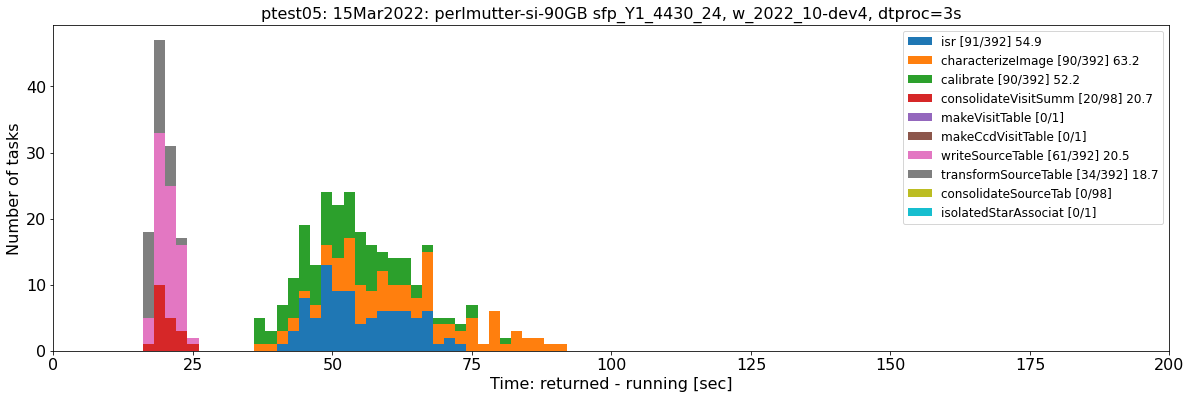

In [7]:
tsk = dbr.table('task')
tsy = dbr.table('try')
print((tsy.task_try_time_running - tsy.task_try_time_launched).dropna().max())
tsyDone = tsy.query("task_try_time_returned==task_try_time_returned")
print(f"         Task count: {len(tsk)}")
print(f"     Task idx count: {len(tsk.task_idx.unique())}")
print(f"  Unique task count: {len(tsk.task_id.unique())}")
print(f"          Try count: {len(tsy)}")
print(f"     Try done count: {len(tsyDone)}")

print()
print("Task name [done/count]")
ntsk = len(dbr.task_names)
tsyDoneByTask = [None]*ntsk
for itsk in range(ntsk):
    tsyDoneByTask[itsk] = tsyDone.query(f"task_idx=={itsk}")
    t1 = tsyDoneByTask[itsk].task_try_time_running
    t2 = tsyDoneByTask[itsk].task_try_time_returned
    nrun = t1.count()
    ndone = t2.count()      # count ignores NaN
    if nrun != ndone:
        savg = f"ERROR: nrun={nrun} != ndone={ndone}"
    elif len(t2):
        avg = (t2-t1).mean()
        savg = f" {avg:.1f}"
    else:
        savg = ''
    print(f"{itsk:4}: {dbr.task_names[itsk]} [{ndone}/{nrun}/{dbr.task_name_counts[itsk]}]{savg}")


x1 = 0
x2 = 200
# Fetch run times for each type of task
taskdts = [None]*ntsk
cols = [None]*ntsk
ncol = len(cols)
labs = [None]*ntsk
#mycols = ['red', 'green', 'orange', 'blue', 'yellow', 'violet', 'cyan', 'pink']
for itsk in range(ntsk):
    t1 = tsyDoneByTask[itsk].task_try_time_running
    t2 = tsyDoneByTask[itsk].task_try_time_returned
    if len(t2):
        avg = (t2-t1).mean()
        savg = f" {avg:.1f}"
    else:
        savg = ''
    taskdts[itsk] = (t2-t1).clip(upper=0.999*x2)
    #cols[itsk] = 'tab:' + mycols[itsk%8]
    labs[itsk] = f"{dbr.task_names[itsk][0:20]} [{len(tsyDoneByTask[itsk])}/{dbr.task_name_counts[itsk]}]{savg}"
    #print(f"Color {cols[itsk]}")
plt.figure(figsize=(pdx, pdy))
plt.hist(bins=100, range=(x1, x2), x=taskdts, stacked=True, label=labs)
plt.legend(loc="upper right", fontsize=12)
plt.xlabel('Time: returned - running [sec]')
plt.ylabel('Number of tasks')
junk = plt.xlim([x1, x2])
plt.title(pttl)
plt.savefig(pfx+'ttask'+sfx)

## Task states
Next look at when the tasks enter eacof the three try states: launched, running and returned.  

The figure shows the (integrated) number of tasks completed as function of time for each task type.

       time   0   1   2   3  4  5   6   7  8  9  all       tfix
0       0.0   0   0   0   0  0  0   0   0  0  0    0   0.000000
1      10.0   0   0   0   0  0  0   0   0  0  0    0   0.166667
2      20.0   0   0   0   0  0  0   0   0  0  0    0   0.333333
3      30.0   0   0   0   0  0  0   0   0  0  0    0   0.500000
4      40.0   0   0   0   0  0  0   0   0  0  0    0   0.666667
..      ...  ..  ..  ..  .. .. ..  ..  .. .. ..  ...        ...
272  2720.0  90  90  90  20  0  0  58  32  0  0  380  45.333333
273  2730.0  90  90  90  20  0  0  59  32  0  0  381  45.500000
274  2740.0  90  90  90  20  0  0  59  32  0  0  381  45.666667
275  2750.0  90  90  90  20  0  0  59  32  0  0  381  45.833333
276  2760.0  90  90  90  20  0  0  61  32  0  0  383  46.000000

[277 rows x 13 columns]


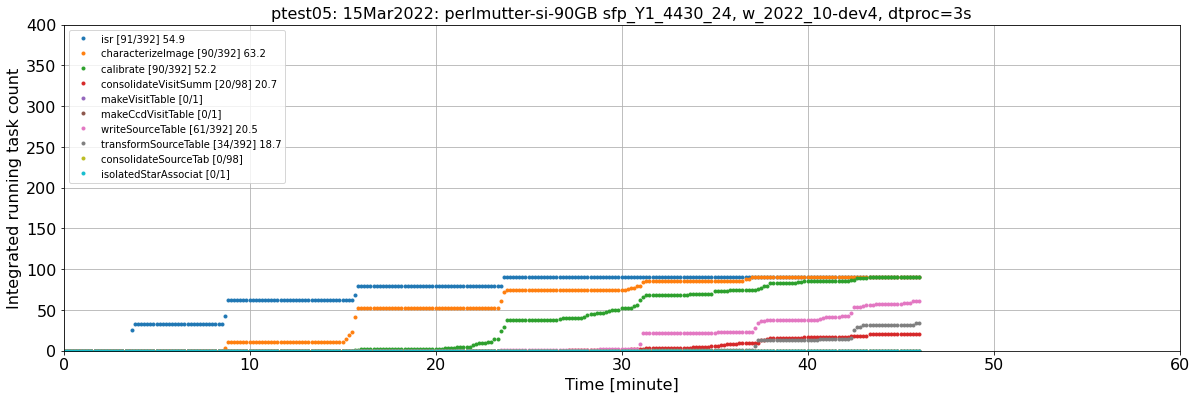

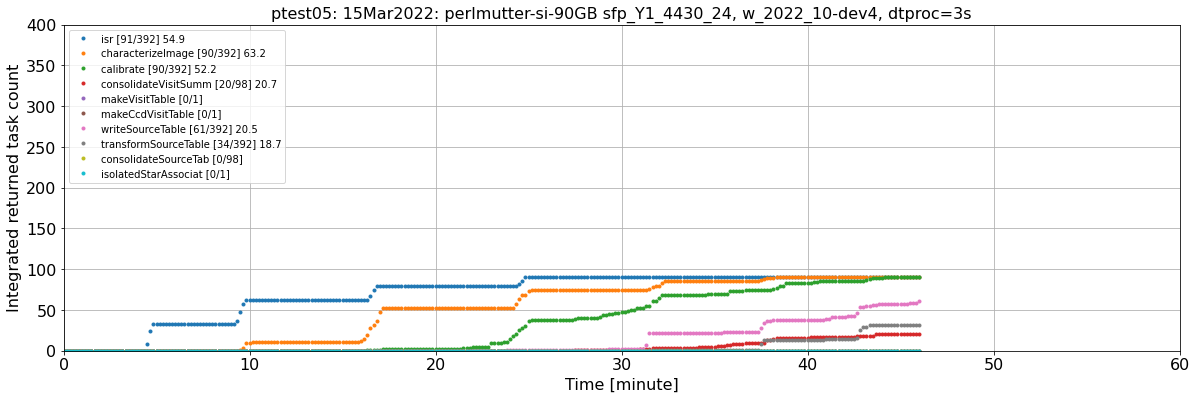

In [8]:
dbr.taskcounts(delt=10)
for dfs in dbr._taskcounts:
    for idf in dfs:
        dfs[idf]['tfix'] = dfs[idf].time/tunit
dbr._taskcounts[0]['running']
print(dbr.taskcounts('returned', 0))
state = 'running'
tsclau = dbr.taskcounts('launched')
tscrun = dbr.taskcounts('running')
tscret = dbr.taskcounts('returned')
for sstat in ['running', 'returned']:
    plt.figure(figsize=(pdx, pdy))
    tsc = dbr.taskcounts(sstat)
    for itsk in range(ntsk):
        plt.plot(tsc.tfix, tsc[itsk], '.', color=cols[itsk%ncol], label=labs[itsk])
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel(f"Integrated {sstat} task count")
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True)
    junk = plt.axis([tmin, tmax, 0, 400])
    plt.title(pttl)
    plt.savefig(f"{pfx}sn{sstat[0:3]}{sfx}")
    plt.show()

This figure shows the total number of jobs launched, started and finished as function of time

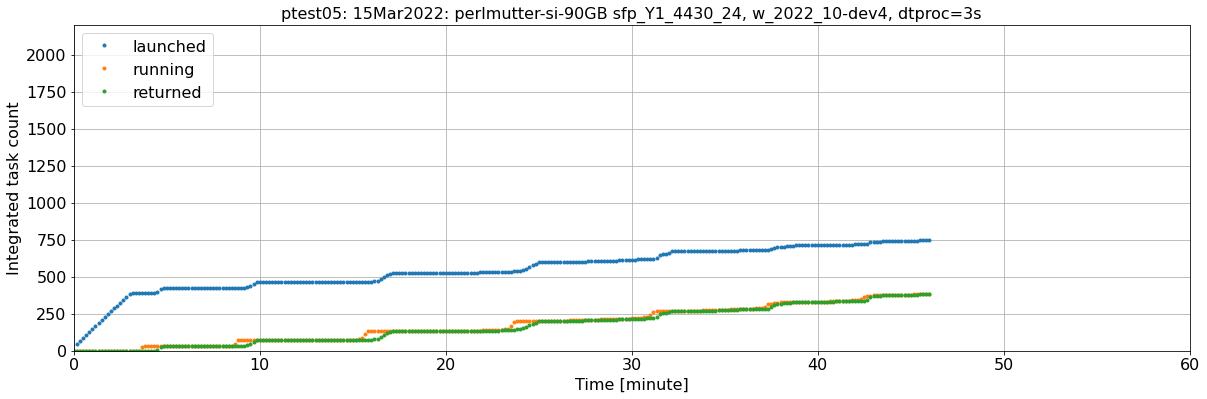

In [9]:
plt.figure(figsize=(pdx, pdy))
plt.plot(tscrun.tfix, tsclau['all'], '.', color=cols[0], label='launched')
plt.plot(tscrun.tfix, tscrun['all'], '.', color=cols[1], label='running')
plt.plot(tscrun.tfix, tscret['all'], '.', color=cols[2], label='returned')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Integrated task count')
plt.legend(loc='upper left')
plt.grid(True)
junk = plt.axis([tmin, tmax, 0, 1.02*len(tsy)])
plt.title(pttl)
plt.savefig(pfx+'nrun'+sfx)
plt.title(pttl)
plt.savefig(pfx+'sntasks'+sfx)

## Running jobs

We would like to know how many tasks were running as function of time.

We plot the difference between the number of tasks started and finished again using the try table.

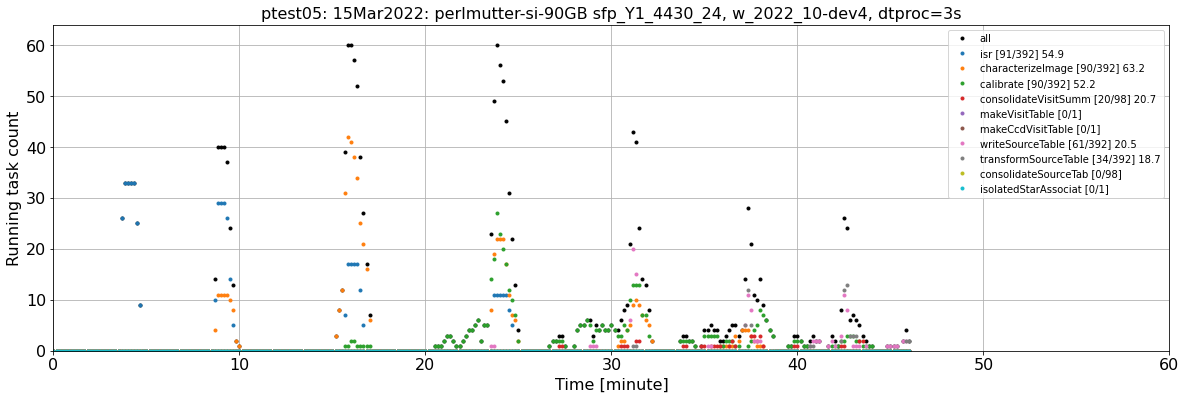

In [10]:
xmin = tmin
xmax = tmax
ymin = 0
ymax = 64
plt.figure(figsize=(pdx, pdy))
tscmem = (tscrun['all'] - tscret['all']).clip(upper=0.999*ymax)
plt.plot(tscrun.tfix, tscmem, '.', color='black', label='all')
for itsk in range(ntsk):
    plt.plot(tscret.tfix, tscrun[itsk] - tscret[itsk], '.', color=cols[itsk%ncol], label=labs[itsk])
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Running task count')
plt.legend(fontsize=10)
plt.title(pttl)
#plt.setp(plt.gca().get_legend().get_texts(), fontsize='8')
plt.grid(True)
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'nruntask'+sfx)

The procsum table also provides the count of jobs running at any time and its totla is compared with that from the try table in the figure below. Both are over time intervals and so offset my lead to slight differences between the two estimates. If one has longer intervals and that interval is comparable to or larger thatn the task run times, then this discrepancy can be large.

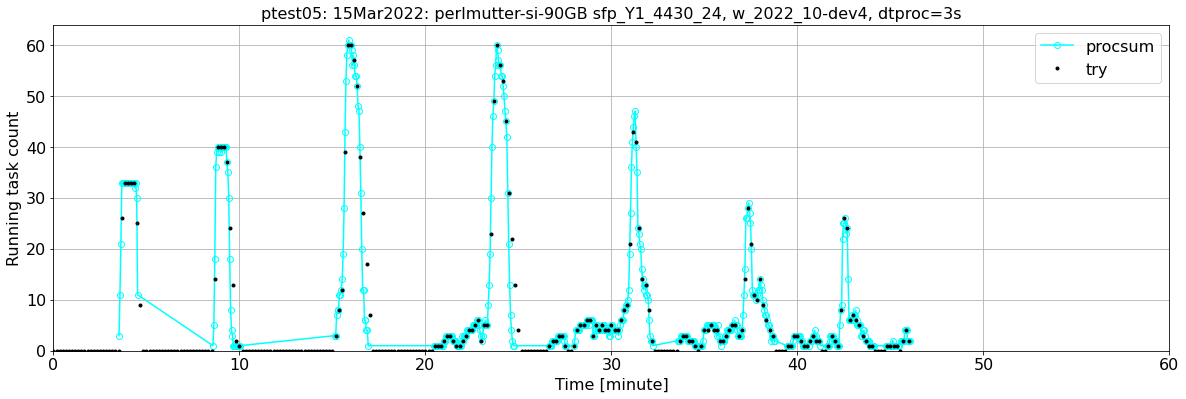

In [11]:
plt.figure(figsize=(pdx, pdy))
plt.plot(psm.tfix, psm.nproc.clip(upper=ymax), color='cyan', marker='o', fillstyle='none', label='procsum')
plt.plot(tscrun.tfix, tscmem, '.', color='black', label='try')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Running task count')
plt.legend()
plt.grid(True)
junk = plt.axis([tmin, tmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'nruncmp'+sfx)

## CPU efficiency

The system monitor records the total CPU time and that in varioys

Procsum provides many estimates of the number of running processes. The counter *nval* holds the number of process entries contributing to each summed sample and *nproc* holds the number of unique process IDs contributing to each sum. These can (rarely?) differ because of jitter in the process sampling times but, more significantly, the process monitior includes an extra sampling at the end of the job which comes in out of phase and may be collected in same sum as the preceding sample. These values are shown as a function of time as lines (*nval* in green and *nproc* in red) in the following plot.

The process monitor also records (and procsum sums) the total CPU time and the CPU time spent in two states: *user* (executing user code) and *system* (performing system operations such as I/O on behalf of the user. The sum of these (*user*+*system*) and *user* alone divided by the total time are shown on the plot with markers.

22.219898785425084


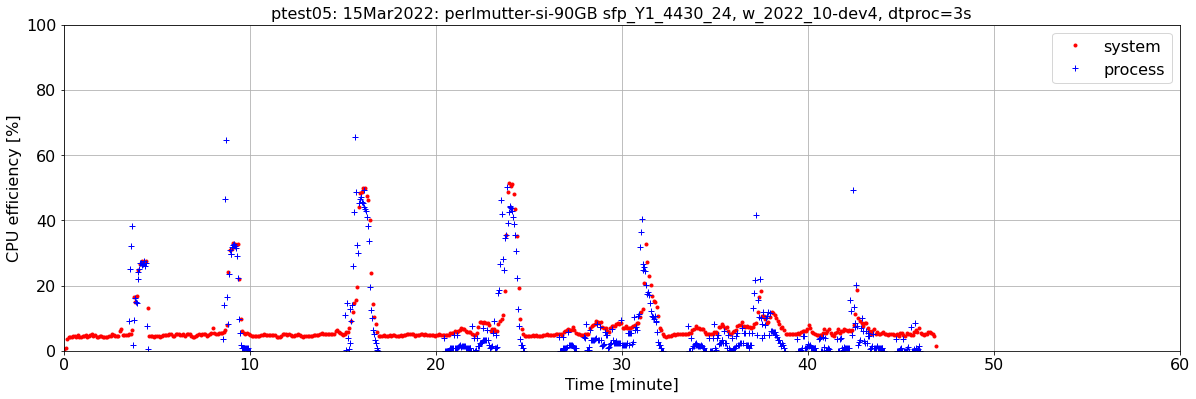

In [12]:
xmin = tmin
xmax = tmax
ymin = 0
ymax = 100
plt.figure(figsize=(pdx, pdy))
plt.plot(sym.tfix, sym.cpu_percent, '.', color='red', label='system')
# To get a process estimate, we divide the total user+sys time by the time interval and number of CPU.
peff = 100*(psm.procsum_time_user+psm.procsum_time_system)/delt/ncpu
plt.plot(psm.tfix, peff.clip(upper=0.999*ymax), 'b+', label='process')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('CPU efficiency [%]')
plt.grid(True)
plt.legend()
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'cpueff'+sfx)
print(psm.procsum_time_user.mean())

## Memory usage

Check sizes: 716 == 716 == 716
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


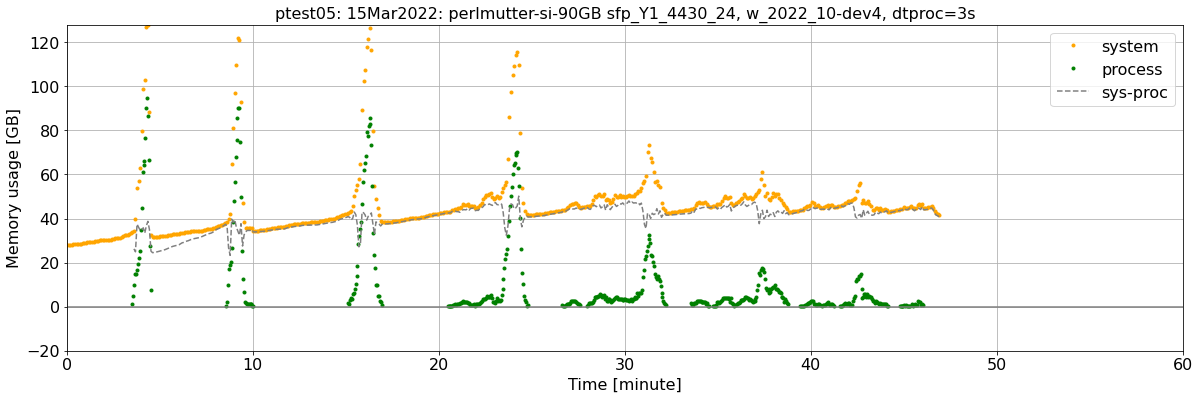

In [13]:
# First build psm2 which holds values with the same times as sym soe
# we can look at the difference between the two.
newidx = sym.tfix
psm2 = psm[['tfix', 'procsum_memory_resident']].set_index('tfix', drop=False)
psm2 = psm2.reindex(psm2.index.union(newidx))
psm2.interpolate('index', inplace=True)
psm2 = psm2.reindex(index=sym.tfix)
psm2['tfix'] = psm2.index
psm2 = psm2.set_index(sym.index)
# Now make the figure
plt.figure(figsize=(pdx, pdy))
ymin = -20
ymax = 128
xmin = tmin
xmax = tmax
smem = ((sym.mem_total - sym.mem_available)/bunit_sys).clip(lower=ymin, upper=ymax)
pmem = psm.procsum_memory_resident/gb
pmem2 = psm2.procsum_memory_resident/gb
diff = smem - pmem2
print(f"Check sizes: {len(smem)} == {len(pmem2)} == {len(diff)}")
print(type(smem), type(pmem2))
#pmem2 = numpy.interp(smem.index, pmem.index, pmem)
plt.plot(sym.tfix, smem, '.', color='orange', label='system')
plt.plot(psm.tfix, pmem, 'g.', label='process')
#plt.plot(psm2.tfix, pmem2, 'b.', label='process, int')
plt.plot(newidx, diff, '--', color='gray', label='sys-proc')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Memory usage [GB]')
plt.legend()
plt.grid(True)
if ymin*ymax < 0.0:
    plt.plot([xmin, xmax], [0,0], '-', color='gray')
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'mem'+sfx)

## I/O rates

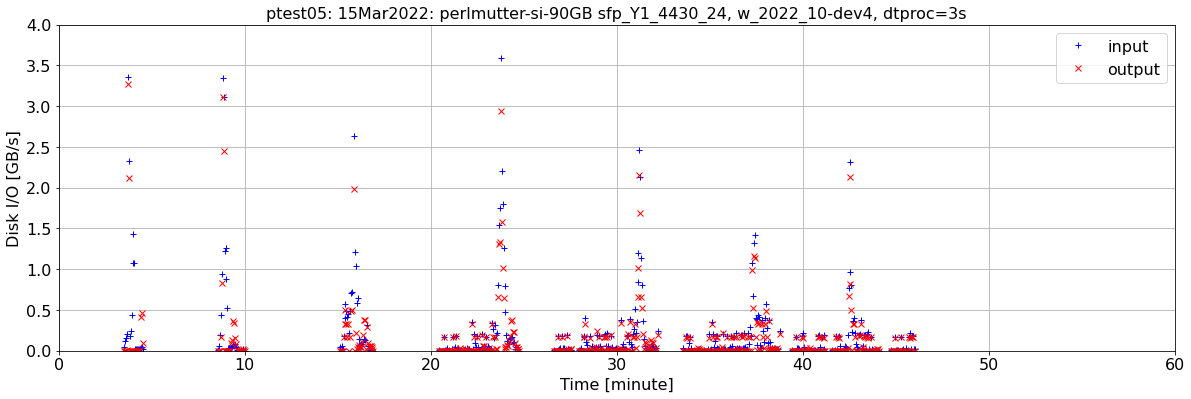

In [14]:
plt.figure(figsize=(pdx, pdy))
plt.plot(psm.tfix, psm.procsum_disk_read/gb/delt, 'b+', label='input')
plt.plot(psm.tfix, psm.procsum_disk_write/gb/delt, 'rx', label='output')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Disk I/O [GB/s]')
plt.grid(True)
plt.legend(loc="upper right")
junk = plt.axis([tmin, tmax, 0, 4])
plt.title(pttl)
plt.savefig(pfx+'io'+sfx)
plt.show()

(0.0, 60.0, 0.0, 600.0)


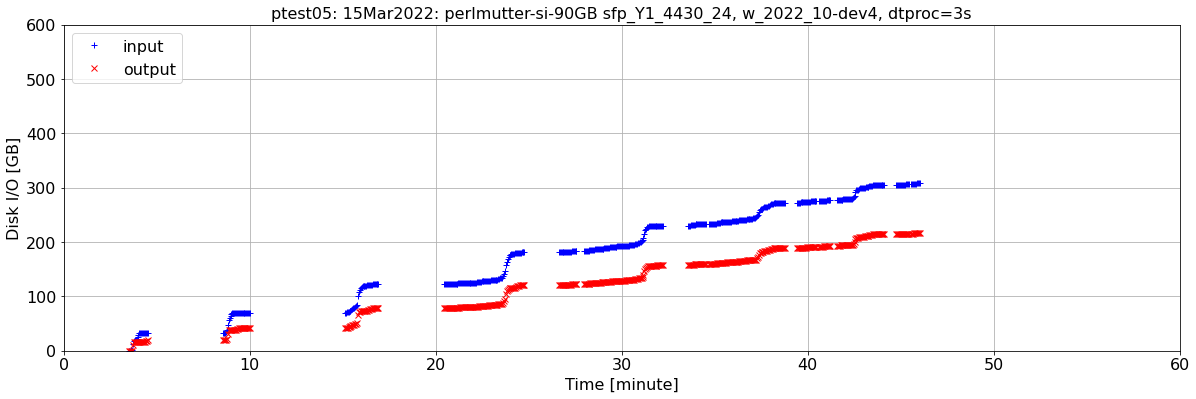

In [15]:
xmin = tmin
xmax = tmax
ymin = 0.0
ymax = 600
plt.figure(figsize=(pdx, pdy))
plt.plot(psm.tfix, psm.procsum_disk_read.cumsum()/gb, 'b+', label='input')
plt.plot(psm.tfix, psm.procsum_disk_write.cumsum()/gb, 'rx', label='output')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Disk I/O [GB]')
plt.grid(True)
plt.legend(loc="upper left")
junk = plt.axis([xmin, xmax, ymin, ymax])
print(junk)
plt.title(pttl)
plt.savefig(pfx+'io2'+sfx)
plt.show()
#print(plt.rcParams)

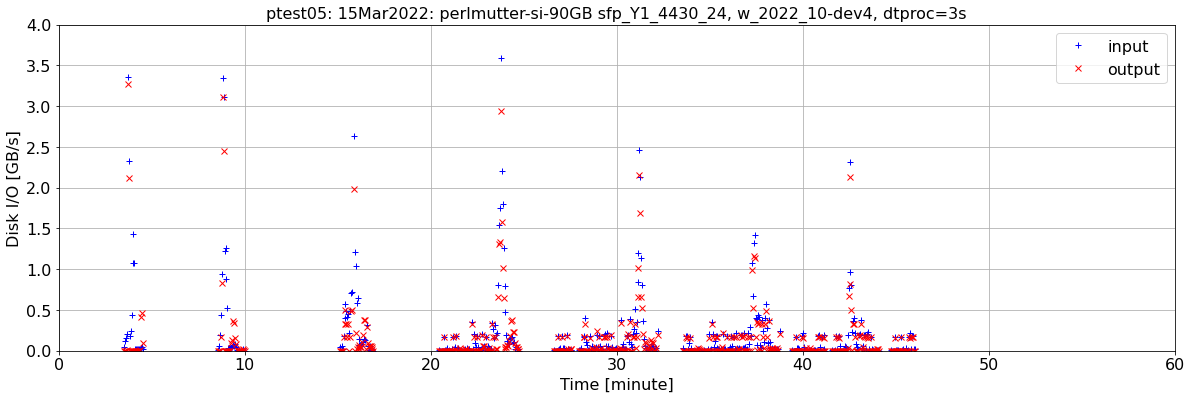

In [16]:
from IPython.display import Image
Image(filename=pfx+'io'+sfx)